<a href="https://colab.research.google.com/github/Satwikram/Explainable-AI-Scene-Classification/blob/main/Explainable%20AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

**Explainable AI: Scene Classification**

In [1]:
! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json


### Downloading Dataset

In [2]:
! kaggle datasets download -d nitishabharathi/scene-classification

 97% 351M/361M [00:05<00:00, 87.6MB/s]
100% 361M/361M [00:05<00:00, 73.0MB/s]


In [ ]:
!unzip /content/scene-classification.zip

### Importing Basic Librarires

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Loading CSV File

In [6]:
train = pd.read_csv('/content/train-scene classification/train.csv')

In [7]:
train.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [8]:
train.shape

(17034, 2)

In [9]:
train['image_name'][0]

'0.jpg'

### Lets move to Working Directory where images are present!

In [10]:
%cd /content/train-scene classification/train

/content/train-scene classification/train


### Lets Visualize some Random Images

In [11]:
train['label'].unique()

array([0, 4, 5, 1, 2, 3])

In [12]:
labels = {0: "Buildings", 1: "Forests", 2: "Mountains", 3: "Glacier", 4: "Sea", 5: "Street"}

In [13]:
labels[0]

'Buildings'

In [14]:
count = 0
for i in range(0, len(train), 2000):
  count = count + 1

print(count)

9


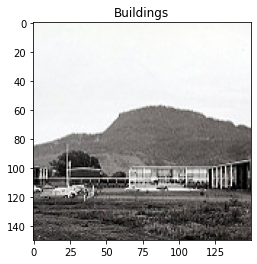

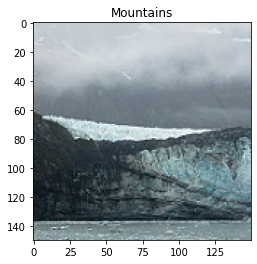

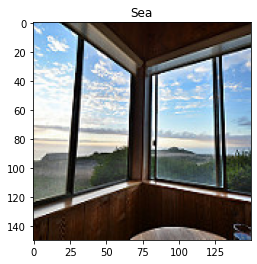

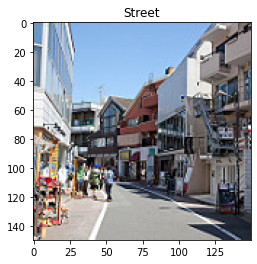

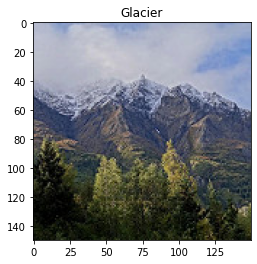

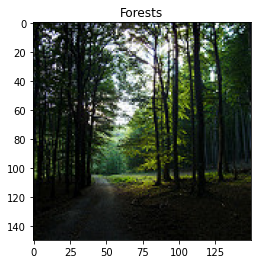

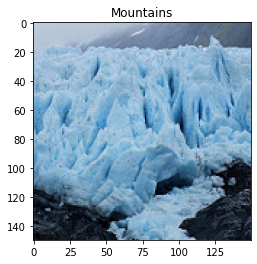

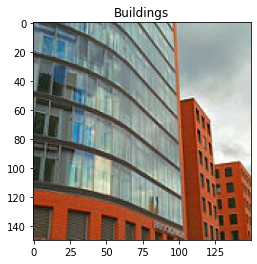

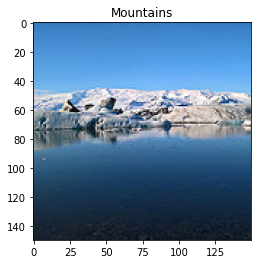

In [15]:
for i in range(0, len(train), 2000):
  plt.imshow(plt.imread(train['image_name'][i]))
  plt.title(labels[train['label'][i]])
  plt.show()

In [16]:
train.head(4)

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0


### Splitting Data into Train and Test

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train, test_size = 0.15)

In [18]:
train.shape

(14478, 2)

In [19]:
test.shape

(2556, 2)

### Image Augmentation and Image Generation

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Creating Data Generator for Training, validation, testing

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255., 
                             validation_split = 0.15,
                             zoom_range = 0.2,
                             horizontal_flip = True)

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255.)

In [23]:
train['label'] = train['label'].apply(lambda x: str(x))

In [24]:
test['label'] = test['label'].apply(lambda x: str(x))

In [25]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory= './',
    x_col = 'image_name',
    y_col = 'label',
    subset="training",
    batch_size = 512,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256)
)

Found 12307 validated image filenames belonging to 6 classes.


In [26]:
valid_generator = train_datagen.flow_from_dataframe(
  dataframe = train,
  directory= './',
  x_col = 'image_name',
  y_col = 'label',
  subset="validation",
  batch_size = 512,
  shuffle=True,
  class_mode="categorical",
  target_size=(256,256)
)

Found 2171 validated image filenames belonging to 6 classes.


In [27]:
test_generator = test_datagen.flow_from_dataframe(
  dataframe=test,
  directory= './',
  x_col='image_name',
  y_col='label',
  batch_size = 512,
  shuffle=False,
  class_mode='categorical',
  target_size=(256,256)
)


Found 2556 validated image filenames belonging to 6 classes.


### Building Resnet Model

In [28]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import *

In [29]:
def res_block(X, filter, stage):
  
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [30]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage
X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage
X = res_block(X, filter= [256,256,1024], stage= 4)

# 5- stage
X = res_block(X, filter= [512,512,2048], stage= 5)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(6, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

### Compiling the Model

In [31]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Callbacks

In [32]:
from tensorflow.keras.callbacks import *

In [33]:
checkpoint = ModelCheckpoint('scene-weights.hdf5', monitor = 'val_loss', save_best_only = True, verbose = 1)

In [34]:
earlystopping = EarlyStopping( monitor = 'val_loss', verbose = 1, restore_best_weights = True,
                                                 patience = 5)

In [35]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [36]:
lr_schedule = LearningRateScheduler(scheduler, verbose = 1)


In [37]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.001, verbose = 1)

In [ ]:
from livelossplot import PlotLossesKeras

In [ ]:
callbacks = [checkpoint, earlystopping, lr_schedule, reduce_lr, PlotLossesKeras()]

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 20, validation_data= valid_generator,
                              validation_steps= valid_generator.n // 32, 
                              callbacks = callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/20


### Loading Weights

In [40]:
my_model = tf.keras.models.load_model('/content/weights.hdf5')

In [ ]:
evaluate = my_model.evaluate_generator(test_generator, steps = test_generator.n // 32, verbose =1)

### Making Prediction

In [48]:
test['image_name']

7743     11060.jpg
848       1224.jpg
14142    20202.jpg
9497     13543.jpg
12031    17176.jpg
           ...    
8449     12042.jpg
9945     14180.jpg
10373    14795.jpg
14599    20864.jpg
16095    22991.jpg
Name: image_name, Length: 2556, dtype: object

In [80]:
num = [7743, 848, 14142, 9497, 12031, 14599, 16095, 10373]

In [57]:
import cv2

In [74]:

labels[int(test['label'][7743])]

'Street'

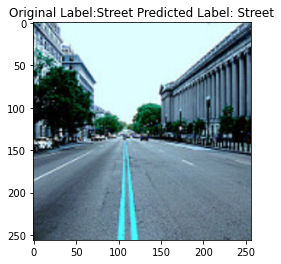

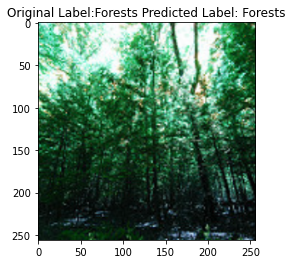

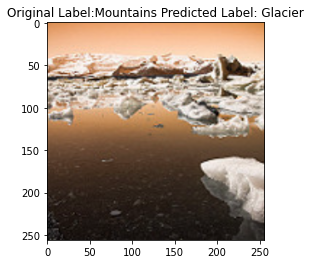

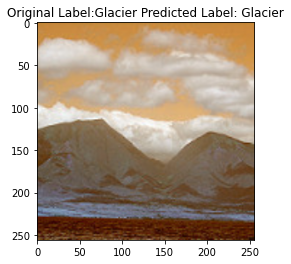

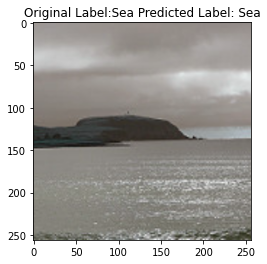

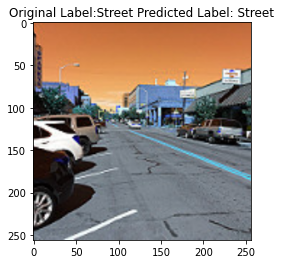

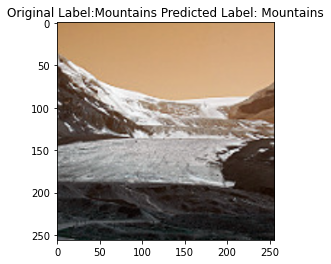

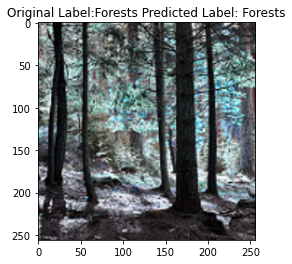

In [87]:
for i in num:
  img = cv2.imread(test['image_name'][i])
  img = cv2.resize(img, (256, 256))
  plt.imshow(img)
  img = np.asarray(img, dtype = np.float32)
  img = img / 255
  img = img.reshape(-1, 256, 256, 3)
  predict = my_model.predict(img)
  predict = np.argmax(predict)
  predict = labels[predict]
  plt.title("Original Label:"+labels[int(test['label'][i])]+" Predicted Label: "+predict)
  plt.show()

### Visualizing Activation Maps Through GRAD-CAM

In [96]:
import tensorflow

In [97]:
def grad_cam(img):

  # Reshape the image from (256,256,3) to (1,256,256,3)
  img = cv2.resize(img, (256, 256))
  img = np.asarray(img, dtype = np.float32)

  img = img.reshape(-1, 256, 256, 3)
  img_scaled = img / 255

  # Name of the average pooling layer and dense final (you can see these names in the model summary)
  classification_layers = ["Averagea_Pooling", "Dense_final"]

  # Last convolutional layer in the model
  final_conv = my_model.get_layer("res_5_identity_2_c")

  # Create a model with original model inputs and the last conv_layer as the output
  final_conv_model = Model(my_model.inputs, final_conv.output)

  classification_input = Input(shape = final_conv.output.shape[1:])

  temp = classification_input
  for layer in classification_layers:
      temp = my_model.get_layer(layer)(temp)
  classification_model = Model(classification_input, temp)

    # We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
  # corresponding to the predicted class
  with tf.GradientTape() as tape:
      # Pass the image through the base model and get the feature map 
      final_conv_output = final_conv_model(img_scaled)

      # Assign gradient tape to monitor the conv_output
      tape.watch(final_conv_output)
      
      # Pass the feature map through the classification model and use argmax to get the 
      # index of the predicted class and then use the index to get the value produced by final
      # layer for that class
      prediction = classification_model(final_conv_output)

      predicted_class = tf.argmax(prediction[0][0][0])

      predicted_class_value = prediction[:,:,:,predicted_class]
  
  # Get the gradient corresponding to the predicted class based on feature map.
  # which is of shape (1,3,3,2048)
  gradient = tape.gradient(predicted_class_value, final_conv_output)

  # Since we need the filter values (2048), we reduce the other dimensions, 
  # which would result in a shape of (2048,)
  gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  # We then convert the feature map produced by last conv layer(1,6,6,1536) to (6,6,1536)
  final_conv_output = final_conv_output.numpy()[0]

  gradient_channels = gradient_channels.numpy()

  # We multiply the filters in the feature map produced by final conv layer by the 
  # filter values that are used to get the predicted class. By doing this we inrease the
  # value of areas that helped in making the prediction and lower the vlaue of areas, that 
  # did not contribute towards the final prediction
  for i in range(gradient_channels.shape[-1]):
      final_conv_output[:, :, i] *= gradient_channels[i]

  # We take the mean accross the channels to get the feature map
  heatmap = np.mean(final_conv_output, axis=-1)

  # Normalizing the heat map between 0 and 1, to visualize it
  heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # Rescaling and converting the type to int
  heatmap = np.uint8(255 * heatmap_normalized )

  # Create the colormap
  color_map = plt.cm.get_cmap('jet')

  # get only the rb features from the heatmap
  color_map = color_map(np.arange(256))[:, :3]
  heatmap = color_map[heatmap]

  # convert the array to image, resize the image and then convert to array
  heatmap = tensorflow.keras.preprocessing.image.array_to_img(heatmap)
  heatmap = heatmap.resize((256, 256))
  heatmap = np.asarray(heatmap, dtype = np.float32)

  # Add the heatmap on top of the original image
  final_img = heatmap * 0.4 + img[0]
  final_img = tensorflow.keras.preprocessing.image.array_to_img(final_img)

  return final_img, heatmap_normalized

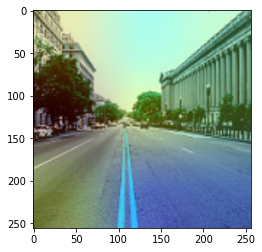

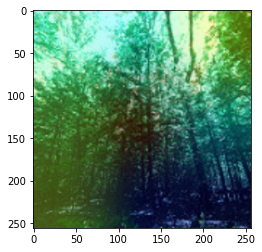

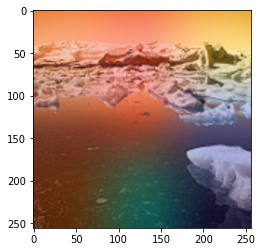

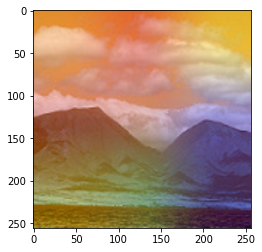

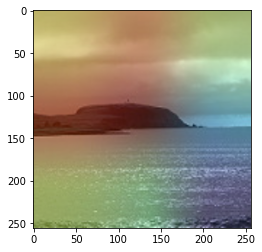

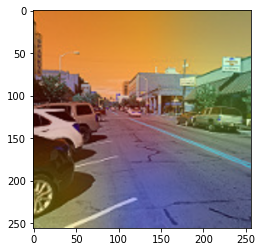

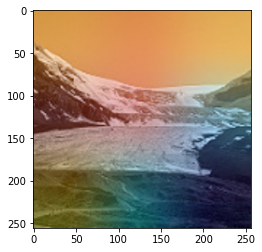

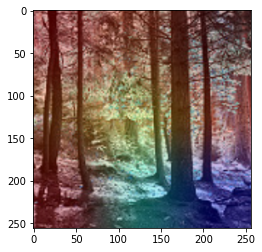

In [107]:
# Visualize the images in the dataset
import random
#fig, axs = plt.subplots(3,3, figsize = (16,32))
count = 0
#for _ in range(6):
for i in num:
  gradcam, heatmap = grad_cam(cv2.imread(test['image_name'][i]))
  plt.imshow(gradcam)
  #plt.imshow(heatmap)
  plt.show()
